In [2]:
import uuid, sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import math
import random
import matplotlib.pyplot as plt
from tqdm import trange

from sklearn import metrics
from scipy import stats
from collections import Counter

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 2 on the node
print(torch.cuda.get_device_name(0))

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
import pytorch_lightning as pl
from torch.optim import AdamW
import training_utils.partitioning_utils as pat_utils

torch.manual_seed(0)

from accelerate import Accelerator
torch.cuda.empty_cache()

Tesla V100-SXM2-32GB


/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'Could not load this library: /work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [3]:
### Setting a seed to have the same initiation of weights

def set_seed(seed: int = 42):
    # Python & NumPy
    random.seed(seed)
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU

    # CuDNN settings (for convolution etc.)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # (Optional) for some Python hashing randomness
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 0
set_seed(SEED)

In [4]:
import wandb
wandb.login()

wandb: Currently logged in as: s232958 (s232958-danmarks-tekniske-universitet-dtu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
os.chdir("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts")
# print(os.getcwd())

print("PyTorch:", torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

PyTorch: 2.9.1+cu128
Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [6]:
# Model parameters
memory_verbose = False
use_wandb = True # Used to track loss in real-time without printing
model_save_steps = 3
train_frac = 1.0
test_frac = 1.0

seq_embedding_dimension = 1280 #| 960 | 1152
number_of_recycles = 2
padding_value = -5000

In [7]:
# ## Training variables
runID = uuid.uuid4()

## Output path
trained_model_dir = f"/work3/s232958/data/trained/with_structure/{runID}"

def print_mem_consumption():
    # 1. Total memory available on the GPU (device 0)
    t = torch.cuda.get_device_properties(0).total_memory
    # 2. How much memory PyTorch has *reserved* from CUDA
    r = torch.cuda.memory_reserved(0)
    # 3. How much of that reserved memory is actually *used* by tensors
    a = torch.cuda.memory_allocated(0)
    # 4. Reserved but not currently allocated (so “free inside PyTorch’s pool”)
    f = r - a

    print("Total memory: ", t/1e9)      # total VRAM in GB
    print("Reserved memory: ", r/1e9)   # PyTorch’s reserved pool in GB
    print("Allocated memory: ", a//1e9) # actually in use (integer division)
    print("Free memory: ", f/1e9)       # slack in the reserved pool in GB
print_mem_consumption()

Total memory:  34.072559616
Reserved memory:  0.0
Allocated memory:  0.0
Free memory:  0.0


### Loading PPint dataframe

In [8]:
Df_train_small = pd.read_csv("/work3/s232958/data/PPint_DB/PPint_train.csv",index_col=0).reset_index(drop=True)
Df_train_small = Df_train_small[~Df_train_small.target_binder_id.str.startswith("6BJP")]
Df_train_small["interface_id"] = [row.ID1.split("_")[0]+"_"+row.ID1.split("_")[1] for __, row in Df_train_small.iterrows()]
Df_test_small = pd.read_csv("/work3/s232958/data/PPint_DB/PPint_test.csv",index_col=0).reset_index(drop=True)
Df_test_small["interface_id"] = [row.ID1.split("_")[0]+"_"+row.ID1.split("_")[1] for __, row in Df_test_small.iterrows()] 


Df_train = pd.read_csv("/work3/s232958/data/PPint_DB/PPint_train_w_pbd_lens.csv",index_col=0).reset_index(drop=True)
Df_train = Df_train.merge(Df_train_small[["dimer", "interface_id"]], on = "interface_id", how="inner")
Df_test = pd.read_csv("/work3/s232958/data/PPint_DB/PPint_test_w_pbd_lens.csv",index_col=0).reset_index(drop=True)
Df_test = Df_test.merge(Df_test_small[["dimer", "interface_id"]], on = "interface_id", how="inner")
Df_train = Df_train[~Df_train.PDB.str.startswith("6BJP")]

Df_train

,interface_id,PDB,ID1,ID2,seq_target,seq_target_len,seq_pdb_target,pdb_target_len,target_chain,seq_binder,seq_binder_len,seq_pdb_binder,pdb_binder_len,binder_chain,pdb_path,dimer
0,6IDB_0,6IDB,6IDB_0_A,6IDB_0_B,DKICLGHHAVSNGTKVNTLTERGVEVVNATETVERTNIPRICSKGK...,317,DKICLGHHAVSNGTKVNTLTERGVEVVNATETVERTNIPRICSKGK...,317,A,GLFGAIAGFIENGWEGLIDGWYGFRHQNAQGEGTAADYKSTQSAID...,172,GLFGAIAGFIENGWEGLIDGWYGFRHQNAQGEGTAADYKSTQSAID...,172,B,6idb.pdb.gz,False
1,2WZP_3,2WZP,2WZP_3_D,2WZP_3_G,VQLQESGGGLVQAGGSLRLSCTASRRTGSNWCMGWFRQLAGKEPEL...,122,VQLQESGGGLVQAGGSLRLSCTASRRTGSNWCMGWFRQLAGKEPEL...,122,D,TIKNFTFFSPNSTEFPVGSNNDGKLYMMLTGMDYRTIRRKDWSSPL...,266,TIKNFTFFSPNSTEFPVGSNNDGKLYMMLTGMDYRTIRRKDWSSPL...,266,G,2wzp.pdb.gz,False
2,1ZKP_0,1ZKP,1ZKP_0_A,1ZKP_0_C,LYFQSNAKTVVGFWGGFPEAGEATSGYLFEHDGFRLLVDCGSGVLA...,246,LYFQSNAMKMTVVGFWGGFPEAGEATSGYLFEHDGFRLLVDCGSGV...,251,A,AKTVVGFWGGFPEAGEATSGYLFEHDGFRLLVDCGSGVLAQLQKYI...,240,AMKMTVVGFWGGFPEAGEATSGYLFEHDGFRLLVDCGSGVLAQLQK...,245,C,1zkp.pdb.gz,True
3,6GRH_3,6GRH,6GRH_3_C,6GRH_3_D,SKHELSLVEVTHYTDPEVLAIVKDFHVRGNFASLPEFAERTFVSAV...,266,SKHELSLVEVTHYTDPEVLAIVKDFHVRGNFASLPEFAERTFVSAV...,266,C,MINVYSNLMSAWPATMAMSPKLNRNMPTFSQIWDYERITPASAAGE...,396,MINVYSNLMSAWPATMAMSPKLNRNMPTFSQIWDYERITPASAAGE...,396,D,6grh.pdb.gz,False
4,8R57_1,8R57,8R57_1_M,8R57_1_f,DLMTALQLVMKKSSAHDGLVKGLREAAKAIEKHAAQICVLAEDCDQ...,118,DLMTALQLVMKKSSAHDGLVKGLREAAKAIEKHAAQICVLAEDCDQ...,118,M,PKKQKHKHKKVKLAVLQFYKVDDATGKVTRLRKECPNADCGAGTFM...,64,PKKQKHKHKKVKLAVLQFYKVDDATGKVTRLRKECPNADCGAGTFM...,64,f,8r57.pdb.gz,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972,4YO8_0,4YO8,4YO8_0_A,4YO8_0_B,HENLYFQGVQKIGILGAMREEITPILELFGVDFEEIPLGGNVFHKG...,238,HENLYFQGVQKIGILGAMREEITPILELFGVDFEEIPLGGNVFHKG...,238,A,HHHHHENLYFQGVQKIGILGAMREEITPILELFGVDFEEIPLGGNV...,242,HHHHHENLYFQGVQKIGILGAMREEITPILELFGVDFEEIPLGGNV...,242,B,4yo8.pdb.gz,True
1973,3CKI_0,3CKI,3CKI_0_A,3CKI_0_B,DPMKNTCKLLVVADHRFYRYMGRGEESTTTNYLIELIDRVDDIYRN...,256,DPMKNTCKLLVVADHRFYRYMGRGEESTTTNYLIELIDRVDDIYRN...,256,A,CTCSPSHPQDAFCNSDIVIRAKVVGKKLVKEGPFGTLVYTIKQMKM...,121,CTCSPSHPQDAFCNSDIVIRAKVVGKKLVKEGPFGTLVYTIKQMKM...,121,B,3cki.pdb.gz,False
1974,7MHY_1,7MHY,7MHY_1_M,7MHY_1_N,QVQLRQSGAELAKPGASVKMSCKASGYTFTNYWLHWIKQRPGQGLE...,118,QVQLRQSGAELAKPGASVKMSCKASGYTFTNYWLHWIKQRPGQGLE...,118,M,DVLMTQTPLSLPVSLGDQVSISCRSSQSIVHNTYLEWYLQKPGQSP...,109,DVLMTQTPLSLPVSLGDQVSISCRSSQSIVHNTYLEWYLQKPGQSP...,109,N,7mhy.pdb.gz,False
1975,7MHY_2,7MHY,7MHY_2_O,7MHY_2_P,IQLVQSGPELVKISCKASGYTFTNYGMNWVRQAPGKGLKWMGWINT...,100,IQLVQSGPELVKISCKASGYTFTNYGMNWVRQAPGKGLKWMGWINT...,100,O,VLMTQTPLSLPVSISCRSSQSIVHSNGNTYLEWYLQKPGQSPKLLI...,94,VLMTQTPLSLPVSISCRSSQSIVHSNGNTYLEWYLQKPGQSPKLLI...,94,P,7mhy.pdb.gz,False


#### Plotting single instance (contact map --> unfolding(x) --> sinPE --> sinPE + unfolded(contact_map))

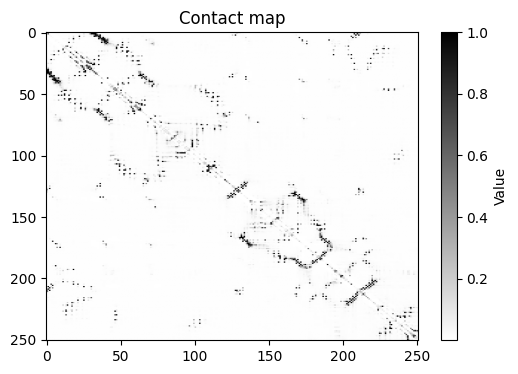

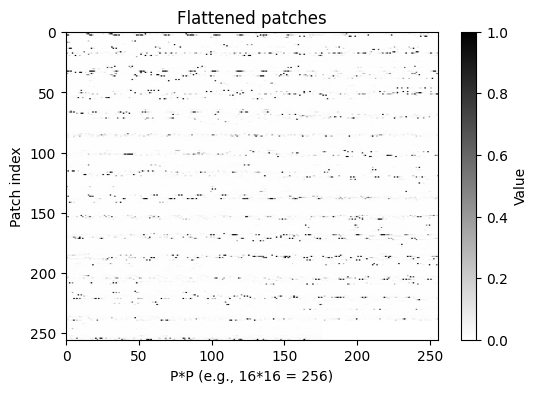

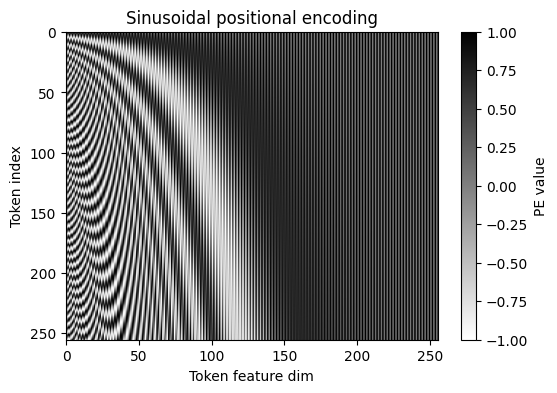

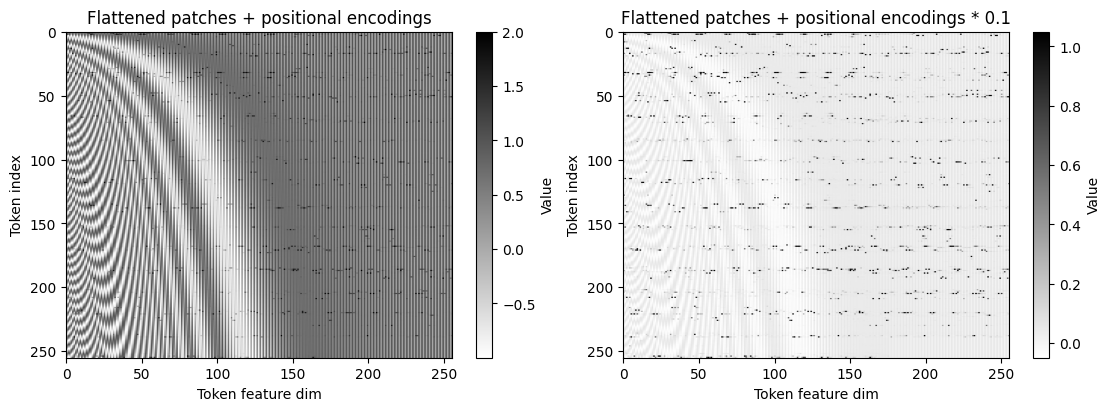

In [9]:
# --- sinusoidal PE ---
def get_sinusoid_encoding(num_tokens: int, token_len: int) -> torch.FloatTensor:
    """
    Make sinusoidal position encoding table.

    Args:
        num_tokens (int): number of tokens (sequence length, L)
        token_len (int): token feature dimension (D)

    Returns:
        torch.FloatTensor of shape [1, L, D]
    """
    def get_position_angle_vec(i):
        return [i / np.power(10000, 2 * (j // 2) / token_len) for j in range(token_len)]

    sinusoid_table = np.array([get_position_angle_vec(i) for i in range(num_tokens)], dtype=np.float32)
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return torch.from_numpy(sinusoid_table).unsqueeze(0)  # [1, L, D]

# --- params & data ---
p = 16  # patch size
#6M9S_0_A_6M9S_0_B
cont_np = np.load("/work3/s232958/data/PPint_DB/contacts_esm2/1NNW_A.npy")  # [N, N], float or int

# --- Contact map ---
fig = plt.figure(figsize=(6, 4))
plt.title('Contact map')
im = plt.imshow(cont_np, cmap='gray_r', aspect='auto')
fig.colorbar(im, ax=plt.gca(), label='Value')

# --- Torch tensor prep (NCHW) ---
x = torch.tensor(cont_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1, 1, N, N]

N = cont_np.shape[0]
H = ((N + p - 1) // p) * p   # next multiple of p
ph = H - N                   # pad amount for right & bottom

# pad order in F.pad is (left, right, top, bottom)
x = F.pad(x, (0, ph, 0, ph), value=0.0)  # [1, 1, H, H]

# --- Patchify (non-overlapping p x p) ---
unfold = nn.Unfold(kernel_size=p, stride=p)
patches = unfold(x)                            # [N, C*p*p, L] --> [1, 1*p*p, L] N - # of images (1), C - # of channels (1), L - # of patches 
tokens = patches.squeeze(0).transpose(0, 1)    # [L, p*p] -> [L, D]
tokens = tokens.contiguous()

# --- Visualize flattened patches ---
fig = plt.figure(figsize=(6, 4))
plt.title('Flattened patches')
plt.xlabel(f'P*P (e.g., {p}*{p} = {p*p})')
plt.ylabel('Patch index')
im = plt.imshow(tokens.cpu().numpy(), cmap='gray_r', aspect='auto')
fig.colorbar(im, ax=plt.gca(), label='Value')

# --- Ensure feature dim is 256 (p=16 -> 256) ---
D_target = p*p
L, D = tokens.shape
if D < D_target:
    feat_pad = torch.zeros(L, D_target - D, dtype=tokens.dtype, device=tokens.device)
    tokens = torch.cat([tokens, feat_pad], dim=1)
elif D > D_target:
    tokens = tokens[:, :D_target]
# now tokens is [L, 256]

# --- Positional encodings ---
positional_embedding = get_sinusoid_encoding(num_tokens=tokens.shape[0], token_len=tokens.shape[1])  # [1, L, 256]
pe = positional_embedding.squeeze(0)  # [L, 256]

# visualize PE
fig = plt.figure(figsize=(6, 4))
plt.title('Sinusoidal positional encoding')
plt.xlabel('Token feature dim')
plt.ylabel('Token index')
im = plt.imshow(pe.cpu().numpy(), cmap='gray_r', aspect='auto', vmin=-1, vmax=1)
fig.colorbar(im, ax=plt.gca(), label='PE value')

# --- Add PE to tokens (no normalization here) ---
# --- Add PE to tokens (no normalization here) ---
flat1 = tokens + pe            # [L, 256]
flat2 = tokens + pe * 0.05     # [L, 256]

arr1 = flat1.detach().cpu().numpy()
arr2 = flat2.detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True)

# Panel 1
im1 = axes[0].imshow(arr1, cmap='gray_r', aspect='auto')
axes[0].set_title('Flattened patches + positional encodings')
axes[0].set_xlabel('Token feature dim')
axes[0].set_ylabel('Token index')
fig.colorbar(im1, ax=axes[0], label='Value')

# Panel 2
im2 = axes[1].imshow(arr2, cmap='gray_r', aspect='auto')
axes[1].set_title('Flattened patches + positional encodings * 0.1')
axes[1].set_xlabel('Token feature dim')
axes[1].set_ylabel('Token index')
fig.colorbar(im2, ax=axes[1], label='Value')

plt.show()

- Flattened patches are very low-magnitude & sparse (values ~0–1, mostly near 0).
- Sinusoidal PE is large and dense (±1 across all dims).
- In the bottom panel, **PE visually dominates** the token values once added. That means attention mostly “sees” the sinusoid, not your contact signal.

### PPint dataloader

In [12]:
class CLIP_PPint_class_w_contacts(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim=1280,
        embedding_pad_value=-5000.0,
        structure_pad_value=0.0,
        p=16
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = embedding_dim
        self.emb_pad = embedding_pad_value
        self.struct_pad = structure_pad_value
        self.p = p

        # lengths
        self.max_blen = self.dframe["pdb_binder_len"].max()+2
        self.max_tlen = self.dframe["pdb_target_len"].max()+2

        # patch extractor
        # patchify --> flatten each patch to p*p dim=1 --> stack pacthes
        # self.unfold = nn.Unfold(kernel_size=self.p, stride=self.p)
        self.unfold = nn.Unfold(kernel_size=self.p, stride=p)

        # paths
        self.encodings_path, self.contacts_path = paths

        # index & storage
        self.dframe.set_index("interface_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
            tgt_id = accession.split("_")[0]+"_"+str(self.dframe.loc[accession].target_chain)
            bnd_id = accession.split("_")[0]+"_"+str(self.dframe.loc[accession].binder_chain)

            ### --- embeddings (pad to fixed lengths) --- ###
                        
            # laod embeddings
            t_emb = np.load(os.path.join(self.encodings_path, f"{tgt_id}.npy"))     # [Lt, D]
            b_emb = np.load(os.path.join(self.encodings_path, f"{bnd_id}.npy"))     # [Lb, D]

            # print(b_emb.shape[0], self.dframe.loc[accession].seq_binder_len)
            assert (b_emb.shape[0] == self.dframe.loc[accession].pdb_binder_len+2)
            assert (t_emb.shape[0] == self.dframe.loc[accession].pdb_target_len+2)

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            ### --- contacts → tokens (zero pad for patching, unfold, add sinusoid PE, pad to global patch indeces length) --- ###
            
            t_cont = np.load(os.path.join(self.contacts_path, f"{tgt_id}.npy"))    # [Lt, Lt]
            b_cont = np.load(os.path.join(self.contacts_path, f"{bnd_id}.npy"))    # [Lb, Lb]

            t_tok = self._contact_to_tokens(t_cont)                  # [L_s_t, p*p]
            b_tok = self._contact_to_tokens(b_cont)                  # [L_s_b, p*p]

            self.samples.append((b_emb, t_emb, b_tok, t_tok))

    def _contact_to_tokens(self, cont_np: np.ndarray) -> torch.Tensor:
        """
        Purpose: return flattened stacked patches
        """        
        # to NCHW
        x = torch.from_numpy(cont_np).float()[None, None, ...]   # [1,1,N,N]

        # zero-pad right and bototm to be divisible by p
        N = cont_np.shape[0]
        Hs = ((N + self.p - 1) // self.p) * self.p
        pad = Hs - N
        x = F.pad(x, (0, pad, 0, pad), value=0.0) # [1,1,Hs,Hs]

        # unfold to non-overlapping p×p
        # squeeze [1, p*p, Ls] --> transpose [p*p, Ls] --> [Ls, p*p]
        cols = self.unfold(x).squeeze(0).transpose(0, 1).contiguous()  
        return cols

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr, b_tok, t_tok = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        binder_ct, target_ct = b_tok.float(), t_tok.float()
        label = torch.tensor(1, dtype=torch.float32)  # single scalar labe
        return binder_emb, target_emb, binder_ct, target_ct, label

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, bct_list, tct_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Keep contacts as lists
        bct = [torch.as_tensor(x) for x in bct_list]
        tct = [torch.as_tensor(x) for x in tct_list]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, bct, tct, labels

In [13]:
emb_path = "/work3/s232958/data/PPint_DB/embeddings_esm2"
cont_path = "/work3/s232958/data/PPint_DB/contacts_esm2"

# global_max_blen = int(PPint_interaactions_df["seq_binder_len"].max())
# global_max_tlen = int(PPint_interaactions_df["seq_target_len"].max())

training_Dataset = CLIP_PPint_class_w_contacts(
    Df_train,
    paths=[emb_path, cont_path],
    embedding_dim=1280
)

testing_Dataset = CLIP_PPint_class_w_contacts(
    Df_test,
    paths=[emb_path, cont_path],
    embedding_dim=1280
)

#Loading ESM2 embeddings and contacts: 100%|██████████████████████████████████████████| 494/494 [00:06<00:00, 80.22it/s]


In [20]:
### Getting indeces of non-dimers
indices_non_dimers_val = Df_test[~Df_test["dimer"]].index.tolist()
indices_non_dimers_val[:5]

### Getting accessions of non-dimers
accessions = [Df_test.loc[index].interface_id for index in indices_non_dimers_val]
b, t, bct, tct, labels = testing_Dataset._get_by_name(accessions[:5])
labels

tensor([1., 1., 1., 1., 1.])

In [ ]:
b, t, bct, tct, labels = testing_Dataset._get_by_name(accessions)

for a, b, c, d, e in zip(b, t, bct, tct, labels):
    print(a.shape, b.shape, c.shape, d.shape, e)
    break

### Meta-analysis dataloader

In [16]:
interaction_df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal.csv")[["A_seq", "B_seq", "target_id_mod", "target_binder_ID", "binder"]].rename(columns = {
    "A_seq" : "seq_binder",
    "B_seq" : "seq_target",
    "target_binder_ID" : "binder_id",
    "target_id_mod" : "target_id",
    "binder" : "binder_label"
})
interaction_df["seq_target_len"] = [len(seq) for seq in interaction_df["seq_target"].tolist()]
interaction_df["seq_binder_len"] = [len(seq) for seq in interaction_df["seq_binder"].tolist()]

# Targets df
target_df = interaction_df[["target_id","seq_target"]].rename(columns={"seq_target":"sequence", "target_id" : "ID"})
target_df["seq_len"] = target_df["sequence"].apply(len)
target_df = target_df.drop_duplicates(subset=["ID","sequence"])
target_df = target_df.set_index("ID")

# Binders df
binder_df = interaction_df[["binder_id","seq_binder"]].rename(columns={"seq_binder":"sequence", "binder_id" : "ID"})
binder_df["seq_len"] = binder_df["sequence"].apply(len)
binder_df = binder_df.set_index("ID")

# target_df

# Interaction Dict
interaction_Dict = dict(enumerate(zip(interaction_df["target_id"], interaction_df["binder_id"]), start=1))
interaction_df_shuffled = interaction_df.sample(frac=1, random_state=0).reset_index(drop=True)
interaction_df_shuffled

,seq_binder,seq_target,target_id,binder_id,binder_label,seq_target_len,seq_binder_len
0,DIVEEAHKLLSRAMSEAMENDDPDKLRRANELYFKLEEALKNNDPK...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_124,True,101,62
1,SEELVEKVVEEILNSDLSNDQKILETHDRLMELHDQGKISKEEYYK...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,EGFR_2,EGFR_2_149,False,621,58
2,TINRVFHLHIQGDTEEARKAHEELVEEVRRWAEELAKRLNLTVRVT...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_339,False,101,65
3,DDLRKVERIASELAFFAAEQNDTKVAFTALELIHQLIRAIFHNDEE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1234,False,101,64
4,DEEVEELEELLEKAEDPRERAKLLRELAKLIRRDPRLRELATEVVA...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_48,False,165,65
...,...,...,...,...,...,...,...
3527,SEDELRELVKEIRKVAEKQGDKELRTLWIEAYDLLASLWYGAADEL...,TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFK...,SARS_CoV2_RBD,SARS_CoV2_RBD_25,False,195,63
3528,TEEEILKMLVELTAHMAGVPDVKVEIHNGTLRVTVNGDTREARSVL...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2027,False,101,65
3529,VEELKEARKLVEEVLRKKGDQIAEIWKDILEELEQRYQEGKLDPEE...,DYSFSCYSQLEVNGSQHSLTCAFEDPDVNTTNLEFEICGALVEVKC...,IL7Ra,IL7Ra_90,False,193,63
3530,DAEEEIREIVEKLNDPLLREILRLLELAKEKGDPRLEAELYLAFEK...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1605,False,101,65


In [17]:
class CLIP_Meta_class(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim=1280,
        embedding_pad_value=-5000.0,
        structure_pad_value=0.0,
        p=16,
        fixed_max_blen=None,
        fixed_max_tlen=None,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)
        self.struct_pad = float(structure_pad_value)
        self.p = int(p)

        # lengths
        self.max_blen = self.dframe["seq_binder_len"].max()+2
        self.max_tlen = self.dframe["seq_target_len"].max()+2

        # patch extractor
        # patchify --> flatten each patch to p*p dim=1 --> stack pacthes
        self.unfold = nn.Unfold(kernel_size=self.p, stride=self.p)

        # paths
        self.encoding_bpath, self.encoding_tpath, self.contacts_bpath, self.contacts_tpath = paths

        # index & storage
        self.dframe.set_index("binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
            lbl = torch.tensor(int(self.dframe.loc[accession, "binder_label"]))
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = "_".join(parts[:-1])
            bnd_id = accession

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_tpath, f"{tgt_id}.npy")) # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_bpath, f"{bnd_id}.npy")) # [Lb, D]
            
            assert (b_emb.shape[0] == self.dframe.loc[accession].seq_binder_len+2)
            assert (t_emb.shape[0] == self.dframe.loc[accession].seq_target_len+2)

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            ### --- contacts → tokens (zero pad for patching, unfold, add sinusoid PE, pad to global patch indeces length) --- ###
            
            t_cont = np.load(os.path.join(self.contacts_tpath, f"{tgt_id}.npy"))    # [Lt, Lt]
            b_cont = np.load(os.path.join(self.contacts_bpath, f"{bnd_id}.npy"))    # [Lb, Lb]

            t_tok = self._contact_to_tokens(t_cont)                  # [L_s_t, p*p]
            b_tok = self._contact_to_tokens(b_cont)                  # [L_s_b, p*p]

            self.samples.append((b_emb, t_emb, b_tok, t_tok, lbl))

    def _contact_to_tokens(self, cont_np: np.ndarray) -> torch.Tensor:
        """
        Purpose: return flattened stacked patches
        """        
        # to NCHW
        x = torch.from_numpy(cont_np).float()[None, None, ...]   # [1,1,N,N]

        # zero-pad right and bototm to be divisible by p
        N = cont_np.shape[0]
        Hs = ((N + self.p - 1) // self.p) * self.p
        pad = Hs - N
        x = F.pad(x, (0, pad, 0, pad), value=0.0) # [1,1,Hs,Hs]

        # unfold to non-overlapping p×p
        # squeeze [1, p*p, Ls] --> transpose [p*p, Ls] --> [Ls, p*p]
        cols = self.unfold(x).squeeze(0).transpose(0, 1).contiguous()  
        return cols
        
    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr, b_tok, t_tok, lbls = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        binder_ct, target_ct = b_tok.float(), t_tok.float()
        return binder_emb, target_emb, binder_ct, target_ct, lbls

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, bct_list, tct_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Keep contacts as lists
        bct = [torch.as_tensor(x) for x in bct_list]
        tct = [torch.as_tensor(x) for x in tct_list]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, bct, tct, labels

bemb_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_binders"
temb_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_targets"

## Contact maps paths
bcont_path = "/work3/s232958/data/meta_analysis/binders_contacts"
tcont_path = "/work3/s232958/data/meta_analysis/targets_contacts"

validation_Dataset = CLIP_Meta_class(
    interaction_df_shuffled,
    paths=[bemb_path, temb_path, bcont_path, tcont_path],
    embedding_dim=1280
)

#Loading ESM2 embeddings and contacts: 100%|███████████████████████████████████████| 3532/3532 [00:34<00:00, 102.65it/s]


In [18]:
accs = []
for i, row in interaction_df_shuffled[:100].iterrows():
    if i % 11 == 0:
        accs.append(row.binder_id)
print(accs)
__, __, __, __, lbls = validation_Dataset._get_by_name(accs)
lbls

['FGFR2_124', 'Pdl1_49', 'Mdm2_41', 'FGFR2_1194', 'FGFR2_798', 'FGFR2_1731', 'FGFR2_25', 'InsulinR_74', 'IL7Ra_80', 'FGFR2_967']


tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

### CLIP-model (validation with meta-dataset)

In [16]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    """
    Purpose: return vector indicating which rows are not padded (don't have values = -5000)
    """
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1280] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

def get_sinusoid_encoding(num_tokens, token_len):
    """
    Purpose: positional encoding having the same dimensions as token matrix
    Standard Vaswani sinusoidal positional encoding for a sequence of length L=num_tokens and dim D=token_len.
    Returns: [L, D] tensor (no batch dim).
    """
    device = torch.device("cpu")
    L, D = num_tokens, token_len
    pos = torch.arange(L, dtype=torch.float32, device=device).unsqueeze(1)      # [L,1]
    i   = torch.arange(D, dtype=torch.float32, device=device).unsqueeze(0)      # [1,D]
    div = torch.pow(10000.0, (2 * torch.floor(i/2)) / D)                        # [1,D]
    angles = pos / div                                                          # [L,D]
    pe = torch.zeros(L, D, dtype=torch.float32, device=device)
    pe[:, 0::2] = torch.sin(angles[:, 0::2])
    pe[:, 1::2] = torch.cos(angles[:, 1::2])
    return pe

def pad_tokens_to_L(tokens: torch.Tensor, L_target: int):
    if tokens.dim() == 3:
        B, Ls, D = tokens.shape
        if Ls >= L_target:
            return tokens[:, :L_target, :]
        pad = tokens.new_zeros(B, L_target - Ls, D)
        return torch.cat([tokens, pad], dim=1)
    elif tokens.dim() == 2:
        Ls, D = tokens.shape
        if Ls >= L_target:
            return tokens[:L_target]
        pad = tokens.new_zeros(L_target - Ls, D)
        return torch.cat([tokens, pad], dim=0)
    else:
        raise ValueError(f"Unexpected tokens.dim()={tokens.dim()} (wanted 2 or 3)")

`trained/PPint_retrain10%_0.4_Christian_w_structure/8e6bf541-1f8e-4f66-9d14-0c0b7327765b_checkpoint_3/...`
#### 1. Prep:
- project contact maps to match dim=1280
- add positional encoding using func `get_sinusoid_encoding()`
- pad so that all contact maps would be the same length (use max_target_len, max_binder_len)
- padding mask for all: embeddings, contact maps

#### 2. Flow:
- seq_Trans, struct_Trans (self-attention)
- cross-attention (pep(prot)/struct): struct_to_seq_attn --> update pep/prot trans_embed
- cross-attention (pep/prot)  

In [17]:
class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(
        self,
        padding_value=-5000,
        seq_embed_dimension = 1280,
        struct_embed_dimension = 256,
        num_recycles=2
    ):
        super().__init__()
        self.num_recycles = num_recycles # 2
        self.padding_value = padding_value # -5000
        self.seq_embed_dimension = seq_embed_dimension # 1280
        self.struct_embed_dimension = struct_embed_dimension # 256

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init
        self.struct_alpha = nn.Parameter(torch.tensor(0.0))
        self.pe_scale = nn.Parameter(torch.tensor(0.1))

        ### SEQUENCE ###
        # self attention
        self.seq_encoder = nn.TransformerEncoderLayer(
            d_model=self.seq_embed_dimension, 
            nhead=8,
            dropout=0.1, 
            batch_first=True, 
            dim_feedforward=self.seq_embed_dimension)

        self.norm_seq = nn.LayerNorm(self.seq_embed_dimension)  # For residual additions

        # cross attention
        self.seq_cross_attn = nn.MultiheadAttention(
            embed_dim=self.seq_embed_dimension, 
            num_heads=8,
            dropout=0.1, 
            batch_first=True)

        self.projection_head= nn.Sequential(
            nn.Linear(self.seq_embed_dimension, 640), 
            nn.ReLU(), 
            nn.Linear(640, 320))

        ### STRUCTURE ###
        
        # Linear projection of flat patches
        self.token_project = nn.Linear(
            self.struct_embed_dimension,
            self.seq_embed_dimension, 
            bias=True)

        self.norm_struct = nn.LayerNorm(self.seq_embed_dimension)  # For residual additions
        
        # self attention        
        self.struct_encoder = nn.TransformerEncoderLayer(
            d_model=self.seq_embed_dimension, 
            nhead=8,
            dropout=0.1, 
            batch_first=True, 
            dim_feedforward=self.seq_embed_dimension)

        self.struct_to_seq_attn = nn.MultiheadAttention(
            embed_dim=self.seq_embed_dimension, 
            num_heads=8,
            dropout=0.1, 
            batch_first=True)
                
    def forward(self, pep_emb, prot_emb, pep_contacts_list, prot_contacts_list, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True):

        pep_max_len, prot_max_len = max(x.size(0) for x in pep_contacts_list), max(x.size(0) for x in prot_contacts_list)
        device = pep_emb.device
        
        ### nn.Linear() --> + PE -->padding to max token index 
        # 1. Linear projection of flat contacts
        pep_cm_proj  = [self.token_project(x.to(device)) for x in pep_contacts_list]
        prot_cm_proj  = [self.token_project(x.to(device)) for x in prot_contacts_list]
        del pep_contacts_list, prot_contacts_list
                
        # 2. + positional encoding (unchanged lists, but now scaled)
        pep_pe = [get_sinusoid_encoding(cm.shape[0], cm.shape[1]).to(device) for cm in pep_cm_proj]
        pep_cm_pos = [cm + self.pe_scale * pe for cm, pe in zip(pep_cm_proj, pep_pe)]
        
        prot_pe = [get_sinusoid_encoding(cm.shape[0], cm.shape[1]).to(device) for cm in prot_cm_proj]
        prot_cm_pos = [cm + self.pe_scale * pe for cm, pe in zip(prot_cm_proj, prot_pe)]

        # 3. Pad dim=0 for batch
        pep_cm_pos = torch.stack([pad_tokens_to_L(cm, pep_max_len) for cm in pep_cm_pos], dim=0)
        prot_cm_pos = torch.stack([pad_tokens_to_L(cm, prot_max_len) for cm in prot_cm_pos], dim=0)
        
        # Key padding masks (True = pad -> to be ignored by attention)
        pep_mask_emb = create_key_padding_mask(embeddings = pep_emb, padding_value = self.padding_value).to(device)   # [B, Lp]
        prot_mask_emb = create_key_padding_mask(embeddings = prot_emb, padding_value = self.padding_value).to(device)    # [B, Lt]
        
        pep_mask_cm = create_key_padding_mask(embeddings = pep_cm_pos, padding_value = self.padding_value).to(device)     # [B, Lp_cm]
        prot_mask_cm = create_key_padding_mask(embeddings = prot_cm_pos, padding_value = self.padding_value).to(device)     # [B, Lt_cm]
    
        # Residual states
        pep_emb = pep_emb.to(device).clone()
        prot_emb = prot_emb.to(device).clone()
        pep_contacts = pep_cm_pos.to(device).clone()
        prot_contacts = prot_cm_pos.to(device).clone()
        # pep_emb, prot_emb, pep_contacts, prot_contacts = pep_emb.clone(), prot_emb.clone(), pep_cm_pos.clone(), prot_cm_pos.clone()
    
        for _ in range(self.num_recycles):
            
            # --- Self-attention encoders (embedding streams) ---
            pep_trans_emb = self.seq_encoder(self.norm_seq(pep_emb), src_key_padding_mask=pep_mask_emb)   # [B, Lp, E]
            prot_trans_emb = self.seq_encoder(self.norm_seq(prot_emb), src_key_padding_mask=prot_mask_emb)  # [B, Lt, E]
    
            # --- Self-attention encoders (structure streams) ---
            pep_trans_cm = self.struct_encoder(self.norm_struct(pep_contacts), src_key_padding_mask=pep_mask_cm)   # [B, Lp_cm, E]
            prot_trans_cm = self.struct_encoder(self.norm_struct(prot_contacts), src_key_padding_mask=prot_mask_cm)  # [B, Lt_cm, E]

            # --- Cross-attend to structures ---
            pep_struct_upd, _ = self.struct_to_seq_attn(query=self.norm_seq(pep_trans_emb), key=self.norm_struct(pep_trans_cm), value=self.norm_struct(pep_trans_cm), key_padding_mask=pep_mask_cm)
            prot_struct_upd, _ = self.struct_to_seq_attn(query=self.norm_seq(prot_trans_emb), key=self.norm_struct(prot_trans_cm), value=self.norm_struct(prot_trans_cm), key_padding_mask=prot_mask_cm)

            pep_trans_emb  = pep_trans_emb  + self.struct_alpha.tanh() * pep_struct_upd    # [B, Lp, E]
            prot_trans_emb = prot_trans_emb + self.struct_alpha.tanh() * prot_struct_upd    # [B, Lt, E]
    
            # --- Cross-attend binder vs target ---
            pep_cross,  _  = self.seq_cross_attn(query=self.norm_seq(pep_trans_emb), key=self.norm_seq(prot_trans_emb), value=self.norm_seq(prot_trans_emb), key_padding_mask=prot_mask_emb)
            prot_cross, _  = self.seq_cross_attn(query=self.norm_seq(prot_trans_emb), key=self.norm_seq(pep_trans_emb), value=self.norm_seq(pep_trans_emb), key_padding_mask=pep_mask_emb)
    
            # --- Residual updates ---
            pep_emb = pep_emb + pep_cross
            prot_emb = prot_emb + prot_cross
    
        # Pool (mean over non-masked positions)
        pep_seq_coding   = create_mean_of_non_masked(pep_emb, pep_mask_emb)
        prot_seq_coding  = create_mean_of_non_masked(prot_emb, prot_mask_emb)

        # Projections + L2-normalize
        pep_full   = F.normalize(self.projection_head(pep_seq_coding),   dim=-1)
        prot_full  = F.normalize(self.projection_head(prot_seq_coding),  dim=-1)
    
        if mem_save:
            torch.cuda.empty_cache()
    
        scale  = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_full * prot_full).sum(dim=-1)  # [B]

        # del pep_emb, prot_emb, pep_contacts, prot_contacts
        
        return logits

    def training_step(self, batch, device):
        embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = batch
        # embedding_pep, embedding_prot, contacts_pep, contacts_prot = embedding_pep.to(device), embedding_prot.to(device), contacts_binder.to(device), contacts_prot.to(device)

        # loss of predicting partner using peptide
        positive_logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device)) # F.binary_cross_entropy_with_logits does sigmoid transfromation inside, excepts data, labels
        
        # Negative indexes
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1) # upper triangle
        
        pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
        prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]

        # loss of predicting peptide using partner
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
        negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))
        
        loss = (positive_loss + negative_loss) / 2
 
        # del partner_prediction_loss, peptide_prediction_loss, embedding_pep, embedding_prot
        torch.cuda.empty_cache()
        return loss

    def validation_step_PPint(self, batch, device):
        # Predict on random batches of training batch size
        embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        # contacts_pep, contacts_prot = contacts_pep.to(device), contacts_prot.to(device)
        
        with torch.no_grad():

            positive_logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
            
            # loss of predicting partner using peptide
            positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
            
            # Negaive indexes
            rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)
            
            pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
            prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]
            
            negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
            negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))

            loss = (positive_loss + negative_loss) / 2

            logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            
            # Fill diagonal with positive scores
            diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(embedding_prot.size(0)).to(self.device)
            peptide_predictions = logit_matrix.argmax(dim=0)
            peptide_ranks = logit_matrix.argsort(dim=0).diag() + 1
            peptide_mrr = (peptide_ranks).float().pow(-1).mean()
            
            # partner_accuracy = partner_predictions.eq(labels).float().mean()
            peptide_accuracy = peptide_predictions.eq(labels).float().mean()
    
            del logit_matrix,positive_logits,negative_logits,embedding_pep,embedding_prot

            return loss, peptide_accuracy
    
    def validation_step_MetaDataset(self, batch, device):
        embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        # contacts_pep, contacts_prot = contacts_pep.to(device), contacts_prot.to(device)
        labels = labels.to(device).float()
    
        with torch.no_grad():
            logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot).float()
            loss = F.binary_cross_entropy_with_logits(logits.view(-1), labels.view(-1))
            return logits, loss

    def calculate_logit_matrix(self, embedding_pep, embedding_prot, contacts_pep, contacts_prot):
        
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
        prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]
        
        positive_logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        return logit_matrix

### Train model from scratch with 10% of PPint dataset

In [18]:
model = MiniCLIP_w_transformer_crossattn(
    seq_embed_dimension=seq_embedding_dimension,
    struct_embed_dimension=256,
    num_recycles=number_of_recycles
).to("cuda")

model

MiniCLIP_w_transformer_crossattn(
  (seq_encoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
    )
    (linear1): Linear(in_features=1280, out_features=1280, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1280, out_features=1280, bias=True)
    (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm_seq): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  (seq_cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
  )
  (projection_head): Sequential(
    (0): Linear(in_features=1280, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features

### Trianing loop

In [19]:
def batch(iterable, n=1):
    """Takes any indexable iterable (e.g., a list of observation IDs) and yields contiguous slices of length n."""
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

class TrainWrapper():

    def __init__(self, 
                 model, 
                 train_loader,
                 test_loader,
                 val_loader,
                 test_df,
                 test_dataset,
                 optimizer, 
                 epochs, 
                 runID, 
                 device, 
                 test_indexes_for_auROC = None,
                 auROC_batch_size=10, 
                 model_save_steps=False, 
                 model_save_path=False, 
                 v=False, 
                 wandb_tracker=False):
        
        self.model = model 
        self.training_loader = train_loader
        self.testing_loader = test_loader
        self.validation_loader = val_loader
        self.test_dataset = test_dataset
        self.test_df = test_df
        self.auROC_batch_size = auROC_batch_size
        
        self.EPOCHS = epochs
        self.optimizer = optimizer
        self.device = device
        
        self.wandb_tracker = wandb_tracker
        self.model_save_steps = model_save_steps
        self.verbose = v
        self.best_vloss = 1_000_000
        self.runID = runID
        self.trained_model_dir = model_save_path
        self.print_frequency_loss = 1
        self.test_indexes_for_auROC = test_indexes_for_auROC

    def train_one_epoch(self):

        self.model.train() 
        running_loss = 0

        for batch in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):
            
            if batch[0].size(0) == 1: 
                continue
            
            self.optimizer.zero_grad()
            loss = self.model.training_step(batch, self.device)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()

            del loss, batch
            torch.cuda.empty_cache()
            
        return running_loss / len(self.training_loader)

    def calc_auroc_aupr_on_indexes(self, model, dataset, dataframe, nondimer_indexes, batch_size = 10):

        self.model.eval()
        all_TP_scores, all_FP_scores = [], []
        accessions = [dataframe.loc[index].target_binder_id for index in nondimer_indexes]  # <-- use dataframe
        batches_local = batch(accessions, n=batch_size)
        
        with torch.no_grad():
            for index_batch in tqdm(batches_local, total=int(len(accessions)/batch_size), desc="Calculating AUC"):

                embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = dataset._get_by_name(index_batch)
                embedding_pep, embedding_prot = embedding_pep.to(self.device), embedding_prot.to(self.device)

                # Make sure this matches your model's signature:
                logit_matrix = self.model.calculate_logit_matrix(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
                
                TP_scores = logit_matrix.diag().detach().cpu().tolist()
                all_TP_scores += TP_scores
                
                # Get FP scores from upper triangle (excluding diagonal)
                n = logit_matrix.size(0)
                rows, cols = torch.triu_indices(n, n, offset=1)
                FP_scores = logit_matrix[rows, cols].detach().cpu().tolist()
                all_FP_scores += FP_scores
            
        all_score_predictions = np.array(all_TP_scores + all_FP_scores)
        all_labels = np.array([1]*len(all_TP_scores) + [0]*len(all_FP_scores))
                
        fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_score_predictions)
        auroc = metrics.roc_auc_score(all_labels, all_score_predictions)
        aupr  = metrics.average_precision_score(all_labels, all_score_predictions)
        
        return auroc, aupr, all_TP_scores, all_FP_scores

    def validate(self):
        
        self.model.eval()
        
        running_loss_Meta = 0.0
        all_logits = []
        all_lbls = []
        used_batches_meta = 0

        # --- MetaDataset validation ---
        with torch.no_grad():
            for batch in tqdm(self.validation_loader, total=len(self.validation_loader)):
                if batch[0].size(0) == 1:
                    continue
                __, __, __, __, labels = batch
                logits, loss = self.model.validation_step_MetaDataset(batch, self.device)
                
                running_loss_Meta += loss.item()
                all_logits.append(logits.detach().view(-1).cpu())
                all_lbls.append(labels.detach().view(-1).cpu())
                used_batches_meta += 1
                
            if used_batches_meta > 0:
                val_loss_Meta = running_loss_Meta / used_batches_meta
                all_logits = torch.cat(all_logits).numpy()
                all_lbls   = torch.cat(all_lbls).numpy()
            
                fpr, tpr, thresholds = metrics.roc_curve(all_lbls, all_logits)
                meta_auroc = metrics.roc_auc_score(all_lbls, all_logits)
                meta_aupr  = metrics.average_precision_score(all_lbls, all_logits)

                y_pred = (all_logits >= 0).astype(int)
                y_true = all_lbls.astype(int)
                val_acc_Meta = (y_pred == y_true).mean()
            else:
                val_loss_Meta = float("nan")
                meta_auroc = float("nan")
                meta_aupr = float("nan")
                val_acc_Meta = float("nan")

        # --- PPint validation ---
        running_loss_ValPPint = 0.0
        running_accuracy_ValPPint = 0.0
        used_batches_ppint = 0

        with torch.no_grad():
            for batch in tqdm(self.testing_loader, total=len(self.testing_loader)):
                if batch[0].size(0) == 1:
                    continue
                loss, partner_accuracy = self.model.validation_step_PPint(batch, self.device)
                running_loss_ValPPint += loss.item()
                running_accuracy_ValPPint += partner_accuracy.item()
                used_batches_ppint += 1
                
            if used_batches_ppint > 0:
                val_loss_PPint = running_loss_ValPPint / used_batches_ppint
                val_accuracy_PPint = running_accuracy_ValPPint / used_batches_ppint
            else:
                val_loss_PPint = float("nan")
                val_accuracy_PPint = float("nan")

        # --- AUROC on specific indexes (optional) ---
        if self.test_indexes_for_auROC is not None:
            non_dimer_auc, non_dimer_aupr, ___, ___ = self.calc_auroc_aupr_on_indexes(
                model=self.model, 
                dataset=self.test_dataset,
                dataframe=self.test_df,
                nondimer_indexes=self.test_indexes_for_auROC,
                batch_size=self.auROC_batch_size
            )
            
            return (val_loss_PPint, val_accuracy_PPint,
                    non_dimer_auc, non_dimer_aupr,
                    val_loss_Meta, val_acc_Meta, meta_auroc, meta_aupr)

        else:
            return (val_loss_PPint, val_accuracy_PPint,
                    val_loss_Meta, val_acc_Meta, meta_auroc, meta_aupr)

    def train_model(self):
        
        torch.cuda.empty_cache()
        
        if self.verbose:
            print(f"Training model {str(self.runID)}")

        # --- initial validation before training
        print("Initial validation before starting training")
        if self.test_indexes_for_auROC is not None:
            (val_loss_PPint, val_accuracy_PPint,
             non_dimer_auc, non_dimer_aupr,
             val_loss_Meta, val_acc_Meta, meta_auroc, meta_aupr) = self.validate()
        else:
            (val_loss_PPint, val_accuracy_PPint,
             val_loss_Meta, val_acc_Meta, meta_auroc, meta_aupr) = self.validate()
            non_dimer_auc, non_dimer_aupr = None, None
                
        if self.verbose: 
            print(f'Before training:')
            print(f'Meta Val-Loss {round(val_loss_Meta,4)}')
            print(f'Meta Accuracy: {round(val_acc_Meta,4)}')
            print(f'Meta AUROC: {round(meta_auroc,4)}')
            print(f'Meta AUPR: {round(meta_aupr,4)}')
            print(f'PPint Test-Loss: {round(val_loss_PPint,4)}')
            print(f'PPint Accuracy: {round(val_accuracy_PPint,4)}')
            if non_dimer_auc is not None:
                print(f'PPint non-dimer AUROC: {round(non_dimer_auc,4)}')
                print(f'PPint non-dimer AUPR: {round(non_dimer_aupr,4)}')
        
        if self.wandb_tracker:
            metrics_to_log = {
                "PPint Test-Loss": val_loss_PPint,
                "Meta Val-loss": val_loss_Meta,
                "PPint Accuracy": val_accuracy_PPint,
                "Meta Accuracy": val_acc_Meta,
                "Meta Val-AUROC": meta_auroc,
                "Meta Val-AUPR": meta_aupr,
            }
            if non_dimer_auc is not None:
                metrics_to_log.update({
                    "PPint non-dimer AUROC": non_dimer_auc,
                    "PPint non-dimer AUPR": non_dimer_aupr,
                })
            self.wandb_tracker.log(metrics_to_log)
        
        # --- training loop
        for epoch in tqdm(range(1, self.EPOCHS + 1), total=self.EPOCHS, desc="Epochs"):
            
            torch.cuda.empty_cache()
            
            train_loss = self.train_one_epoch()
            
            # validation after epoch
            if self.test_indexes_for_auROC is not None:
                (val_loss_PPint, val_accuracy_PPint,
                 non_dimer_auc, non_dimer_aupr,
                 val_loss_Meta, val_acc_Meta, meta_auroc, meta_aupr) = self.validate()
            else:
                (val_loss_PPint, val_accuracy_PPint,
                 val_loss_Meta, val_acc_Meta, meta_auroc, meta_aupr) = self.validate()
                non_dimer_auc, non_dimer_aupr = None, None
            
            torch.cuda.empty_cache()
            
            # checkpoint save
            if self.model_save_steps and epoch % self.model_save_steps == 0:
                check_point_folder = os.path.join(self.trained_model_dir, f"{str(self.runID)}_checkpoint_{str(epoch)}")
                if self.verbose:
                    print("Saving model to:", check_point_folder)
                os.makedirs(check_point_folder, exist_ok=True)
                checkpoint_path = os.path.join(check_point_folder, f"{str(self.runID)}_checkpoint_epoch_{str(epoch)}.pth")
                torch.save({'epoch': epoch, 
                            'model_state_dict': self.model.state_dict(),
                            'optimizer_state_dict': self.optimizer.state_dict(), 
                            'val_loss_PPint': val_loss_PPint,
                            'val_loss_Meta': val_loss_Meta},
                           checkpoint_path)
            
            # console logging
            if self.verbose and epoch % self.print_frequency_loss == 0:
                print(f'EPOCH {epoch}:')
                print(f'Meta Val Loss {round(val_loss_Meta,4)}')
                print(f'Meta Accuracy: {round(val_acc_Meta,4)}')
                print(f'Meta AUROC: {round(meta_auroc,4)}')
                print(f'Meta AUPR: {round(meta_aupr,4)}')
                print(f'PPint Test-Loss: {round(val_loss_PPint,4)}')
                print(f'PPint Accuracy: {round(val_accuracy_PPint,4)}')
                if non_dimer_auc is not None:
                    print(f'PPint non-dimer AUROC: {round(non_dimer_auc,4)}')
                    print(f'PPint non-dimer AUPR: {round(non_dimer_aupr,4)}')
            
            # wandb logging
            if self.wandb_tracker:
                metrics_to_log_epoch = {
                    "PPint Train-loss": train_loss,
                    "PPint Test-Loss": val_loss_PPint,
                    "Meta Val-loss": val_loss_Meta,
                    "PPint Accuracy": val_accuracy_PPint,
                    "Meta Accuracy": val_acc_Meta,
                    "Meta Val-AUROC": meta_auroc,
                    "Meta Val-AUPR": meta_aupr,
                }
                if non_dimer_auc is not None:
                    metrics_to_log_epoch.update({
                        "PPint non-dimer AUROC": non_dimer_auc,
                        "PPint non-dimer AUPR": non_dimer_aupr,
                    })
                self.wandb_tracker.log(metrics_to_log_epoch)

        if self.wandb_tracker:
            self.wandb_tracker.finish()

In [20]:
def collate_varlen(batch):
    b_emb = torch.stack([x[0] for x in batch], dim=0)  # fixed length -> stack
    t_emb = torch.stack([x[1] for x in batch], dim=0)
    b_ctok = [x[2] for x in batch]                     # var-len -> list
    t_ctok = [x[3] for x in batch]
    # lbls = torch.tensor([float(x[4]) for x in batch])
    lbls = torch.tensor([x[4].float() for x in batch])
    return b_emb, t_emb, b_ctok, t_ctok, lbls

train_dataloader = DataLoader(training_Dataset, batch_size=5, shuffle=True, collate_fn=collate_varlen)
test_dataloader = DataLoader(testing_Dataset, batch_size=5, shuffle=False, collate_fn=collate_varlen)
val_dataloader = DataLoader(validation_Dataset, batch_size=7, shuffle=False, drop_last = False, collate_fn=collate_varlen)

In [21]:
runID = uuid.uuid4()
learning_rate = 2e-5
EPOCHS = 12
batch_size = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = AdamW(model.parameters(), lr=learning_rate)

# accelerator
accelerator = Accelerator()
model, optimizer, train_dataloader, test_dataloader, val_dataloader = accelerator.prepare(model, optimizer, train_dataloader, test_dataloader, val_dataloader)

device = accelerator.device

for i in val_dataloader:
    __, __, __, __, lbls = i
    print(lbls.to(device))
    break

tensor([1., 0., 0., 0., 0., 0., 0.], device='cuda:0')


In [22]:
# wandb
import wandb
if use_wandb:
    run = wandb.init(
        project="CLIP_retrain_w_PPint0.1",
        name=f"Retrain_PPint0.1_ESM2_w_struct_{runID}",
        config={"learning_rate": learning_rate, 
                "batch_size": batch_size, 
                "epochs": EPOCHS,
                "architecture": "MiniCLIP_w_transformer_crossattn", 
                "dataset": 
                "PPint"},
    )
    wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
else:
    run = None

# train
training_wrapper = TrainWrapper(
            model=model,
            train_loader=train_dataloader,
            test_loader=test_dataloader,
            val_loader=val_dataloader,
            test_df=Df_test,
            test_dataset=testing_Dataset,
            optimizer=optimizer,
            epochs=EPOCHS,
            runID=runID,
            device=device,
            test_indexes_for_auROC=indices_non_dimers_val,
            auROC_batch_size=10,
            model_save_steps=model_save_steps,
            model_save_path=trained_model_dir,
            v=True,
            wandb_tracker=wandb
)

training_wrapper.train_model() # start training

Training model c64cd829-706b-4b6e-b5e6-78596317460b
Initial validation before starting training


100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:24<00:00,  4.12it/s]
Calculating AUC: 13it [00:09,  1.36it/s]                                                                                


Before training:
Meta Val-Loss 10.3991
Meta Accuracy: 0.1107
Meta AUROC: 0.512
Meta AUPR: 0.1273
PPint Test-Loss: 6.2928
PPint Accuracy: 0.8566
PPint non-dimer AUROC: 0.6475
PPint non-dimer AUPR: 0.3865


Running through epoch: 100%|██████████████████████████████████████████████████████████| 396/396 [04:34<00:00,  1.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [01:05<00:00,  7.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:23<00:00,  4.18it/s]

Calculating AUC:  92%|████████████████████████████████████████████████████████████▌     | 11/12 [00:08<00:00,  1.17it/s]
Calculating AUC: 13it [00:09,  1.34it/s]                                                                                
Epochs:   8%|██████                                                                   | 1/12 [06:13<1:08:32, 373.84s/it]

EPOCH 1:
Meta Val Loss 0.4066
Meta Accuracy: 0.8842
Meta AUROC: 0.4543
Meta AUPR: 0.0958
PPint Test-Loss: 0.2381
PPint Accuracy: 0.9071
PPint non-dimer AUROC: 0.734
PPint non-dimer AUPR: 0.3984



Running through epoch: 100%|██████████████████████████████████████████████████████████| 396/396 [04:33<00:00,  1.45it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [01:05<00:00,  7.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:23<00:00,  4.19it/s]

Calculating AUC:  92%|████████████████████████████████████████████████████████████▌     | 11/12 [00:08<00:00,  1.17it/s]
Calculating AUC: 13it [00:09,  1.34it/s]                                                                                
Epochs:  17%|████████████▏                                                            | 2/12 [12:26<1:02:10, 373.02s/it]

EPOCH 2:
Meta Val Loss 0.4466
Meta Accuracy: 0.878
Meta AUROC: 0.4956
Meta AUPR: 0.12
PPint Test-Loss: 0.2262
PPint Accuracy: 0.9091
PPint non-dimer AUROC: 0.76
PPint non-dimer AUPR: 0.4504



Running through epoch: 100%|██████████████████████████████████████████████████████████| 396/396 [04:33<00:00,  1.45it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [01:06<00:00,  7.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:23<00:00,  4.21it/s]

Calculating AUC:  92%|████████████████████████████████████████████████████████████▌     | 11/12 [00:08<00:00,  1.16it/s]
Calculating AUC: 13it [00:09,  1.34it/s]                                                                                


Saving model to: /work3/s232958/data/trained/with_structure/a1cbf8d7-c83b-4d06-8898-80abaa182dab/c64cd829-706b-4b6e-b5e6-78596317460b_checkpoint_3


Epochs:  25%|██████████████████▊                                                        | 3/12 [18:40<56:00, 373.42s/it]

EPOCH 3:
Meta Val Loss 0.4584
Meta Accuracy: 0.8751
Meta AUROC: 0.4674
Meta AUPR: 0.1005
PPint Test-Loss: 0.2236
PPint Accuracy: 0.9111
PPint non-dimer AUROC: 0.7701
PPint non-dimer AUPR: 0.4448



Running through epoch: 100%|██████████████████████████████████████████████████████████| 396/396 [04:34<00:00,  1.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [01:05<00:00,  7.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:23<00:00,  4.20it/s]

Calculating AUC:  92%|████████████████████████████████████████████████████████████▌     | 11/12 [00:08<00:00,  1.16it/s]
Calculating AUC: 13it [00:09,  1.34it/s]                                                                                
Epochs:  33%|█████████████████████████                                                  | 4/12 [24:54<49:48, 373.61s/it]

EPOCH 4:
Meta Val Loss 0.4518
Meta Accuracy: 0.8851
Meta AUROC: 0.5107
Meta AUPR: 0.1292
PPint Test-Loss: 0.2182
PPint Accuracy: 0.9253
PPint non-dimer AUROC: 0.7955
PPint non-dimer AUPR: 0.48



Running through epoch: 100%|██████████████████████████████████████████████████████████| 396/396 [04:35<00:00,  1.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [01:06<00:00,  7.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:23<00:00,  4.20it/s]

Calculating AUC:  92%|████████████████████████████████████████████████████████████▌     | 11/12 [00:08<00:00,  1.17it/s]
Calculating AUC: 13it [00:09,  1.34it/s]                                                                                
Epochs:  42%|███████████████████████████████▎                                           | 5/12 [31:08<43:37, 373.97s/it]

EPOCH 5:
Meta Val Loss 0.4292
Meta Accuracy: 0.8783
Meta AUROC: 0.5188
Meta AUPR: 0.1333
PPint Test-Loss: 0.2524
PPint Accuracy: 0.9172
PPint non-dimer AUROC: 0.7952
PPint non-dimer AUPR: 0.4745



Running through epoch: 100%|██████████████████████████████████████████████████████████| 396/396 [04:34<00:00,  1.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [01:06<00:00,  7.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:23<00:00,  4.19it/s]

Calculating AUC:  92%|████████████████████████████████████████████████████████████▌     | 11/12 [00:08<00:00,  1.17it/s]
Calculating AUC: 13it [00:09,  1.34it/s]                                                                                


Saving model to: /work3/s232958/data/trained/with_structure/a1cbf8d7-c83b-4d06-8898-80abaa182dab/c64cd829-706b-4b6e-b5e6-78596317460b_checkpoint_6


Epochs:  50%|█████████████████████████████████████▌                                     | 6/12 [37:23<37:25, 374.19s/it]

EPOCH 6:
Meta Val Loss 0.4743
Meta Accuracy: 0.8862
Meta AUROC: 0.4885
Meta AUPR: 0.1151
PPint Test-Loss: 0.2561
PPint Accuracy: 0.9253
PPint non-dimer AUROC: 0.7667
PPint non-dimer AUPR: 0.4694



Running through epoch: 100%|██████████████████████████████████████████████████████████| 396/396 [04:35<00:00,  1.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [01:06<00:00,  7.65it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:23<00:00,  4.23it/s]

Calculating AUC:  92%|████████████████████████████████████████████████████████████▌     | 11/12 [00:08<00:00,  1.17it/s]
Calculating AUC: 13it [00:09,  1.35it/s]                                                                                
Epochs:  58%|███████████████████████████████████████████▊                               | 7/12 [43:37<31:11, 374.21s/it]

EPOCH 7:
Meta Val Loss 0.5392
Meta Accuracy: 0.8573
Meta AUROC: 0.4549
Meta AUPR: 0.0967
PPint Test-Loss: 0.244
PPint Accuracy: 0.9247
PPint non-dimer AUROC: 0.7957
PPint non-dimer AUPR: 0.4847



Running through epoch: 100%|██████████████████████████████████████████████████████████| 396/396 [04:34<00:00,  1.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [01:06<00:00,  7.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:23<00:00,  4.21it/s]

Calculating AUC:  92%|████████████████████████████████████████████████████████████▌     | 11/12 [00:08<00:00,  1.16it/s]
Calculating AUC: 13it [00:09,  1.34it/s]                                                                                
Epochs:  67%|██████████████████████████████████████████████████                         | 8/12 [49:52<24:57, 374.31s/it]

EPOCH 8:
Meta Val Loss 0.7541
Meta Accuracy: 0.6181
Meta AUROC: 0.5086
Meta AUPR: 0.1141
PPint Test-Loss: 0.2379
PPint Accuracy: 0.9111
PPint non-dimer AUROC: 0.79
PPint non-dimer AUPR: 0.472



Running through epoch: 100%|██████████████████████████████████████████████████████████| 396/396 [04:33<00:00,  1.45it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [01:05<00:00,  7.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:23<00:00,  4.18it/s]

Calculating AUC:  92%|████████████████████████████████████████████████████████████▌     | 11/12 [00:08<00:00,  1.16it/s]
Calculating AUC: 13it [00:09,  1.33it/s]                                                                                


Saving model to: /work3/s232958/data/trained/with_structure/a1cbf8d7-c83b-4d06-8898-80abaa182dab/c64cd829-706b-4b6e-b5e6-78596317460b_checkpoint_9


Epochs:  75%|████████████████████████████████████████████████████████▎                  | 9/12 [56:05<18:41, 373.88s/it]

EPOCH 9:
Meta Val Loss 0.5375
Meta Accuracy: 0.8044
Meta AUROC: 0.4689
Meta AUPR: 0.1065
PPint Test-Loss: 0.2845
PPint Accuracy: 0.9131
PPint non-dimer AUROC: 0.7779
PPint non-dimer AUPR: 0.4668



Running through epoch: 100%|██████████████████████████████████████████████████████████| 396/396 [04:35<00:00,  1.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [01:05<00:00,  7.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:23<00:00,  4.20it/s]

Calculating AUC:  92%|████████████████████████████████████████████████████████████▌     | 11/12 [00:08<00:00,  1.17it/s]
Calculating AUC: 13it [00:09,  1.35it/s]                                                                                
Epochs:  83%|████████████████████████████████████████████████████████████            | 10/12 [1:02:19<12:28, 374.16s/it]

EPOCH 10:
Meta Val Loss 0.6033
Meta Accuracy: 0.7248
Meta AUROC: 0.5189
Meta AUPR: 0.119
PPint Test-Loss: 0.2564
PPint Accuracy: 0.9253
PPint non-dimer AUROC: 0.7841
PPint non-dimer AUPR: 0.4593



Running through epoch: 100%|██████████████████████████████████████████████████████████| 396/396 [04:35<00:00,  1.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [01:07<00:00,  7.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:23<00:00,  4.19it/s]

Calculating AUC:  92%|████████████████████████████████████████████████████████████▌     | 11/12 [00:08<00:00,  1.17it/s]
Calculating AUC: 13it [00:09,  1.34it/s]                                                                                
Epochs:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [1:08:35<06:14, 374.70s/it]

EPOCH 11:
Meta Val Loss 0.5067
Meta Accuracy: 0.8884
Meta AUROC: 0.5018
Meta AUPR: 0.1165
PPint Test-Loss: 0.2312
PPint Accuracy: 0.9333
PPint non-dimer AUROC: 0.7979
PPint non-dimer AUPR: 0.4681



Running through epoch: 100%|██████████████████████████████████████████████████████████| 396/396 [04:34<00:00,  1.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [01:06<00:00,  7.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:23<00:00,  4.22it/s]

Calculating AUC:  92%|████████████████████████████████████████████████████████████▌     | 11/12 [00:08<00:00,  1.18it/s]
Calculating AUC: 13it [00:09,  1.35it/s]                                                                                


Saving model to: /work3/s232958/data/trained/with_structure/a1cbf8d7-c83b-4d06-8898-80abaa182dab/c64cd829-706b-4b6e-b5e6-78596317460b_checkpoint_12


Epochs: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [1:14:50<00:00, 374.22s/it]

EPOCH 12:
Meta Val Loss 0.585
Meta Accuracy: 0.8884
Meta AUROC: 0.4766
Meta AUPR: 0.1052
PPint Test-Loss: 0.3037
PPint Accuracy: 0.9313
PPint non-dimer AUROC: 0.8184
PPint non-dimer AUPR: 0.4959


Meta Accuracy,▁███████▆▇▇██
Meta Val-AUPR,▇▁▆▂▇█▅▁▄▃▅▅▃
Meta Val-AUROC,▇▁▅▂▇█▅▁▇▃█▆▃
Meta Val-loss,█▁▁▁▁▁▁▁▁▁▁▁▁
PPint Accuracy,▁▆▆▆▇▇▇▇▆▆▇██
PPint Test-Loss,█▁▁▁▁▁▁▁▁▁▁▁▁
PPint Train-loss,█▄▃▃▂▂▂▂▁▁▁▁
PPint non-dimer AUPR,▁▂▅▅▇▇▆▇▆▆▆▆█
PPint non-dimer AUROC,▁▅▆▆▇▇▆▇▇▆▇▇█
Meta Accuracy,0.88845
Meta Val-AUPR,0.10524
